In [1]:
# python 3.10 tf 2.8

import cv2
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from keras.layers import *
from keras.models import *
import keras
import numpy as np

데이터셋 준비
tfds를 활용할 것임. 
tfds는 다양하게 활용 가능함. train만 만들수도 있고 용도에 따라 test까지 만들 수 있음.

In [2]:
(raw_train, raw_validation, raw_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='C:\\Users\\Administrator\\tensorflow_datasets\\cats_vs_dogs\\4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) an

이미지 시각화(label 이름도 같이 보여줌)

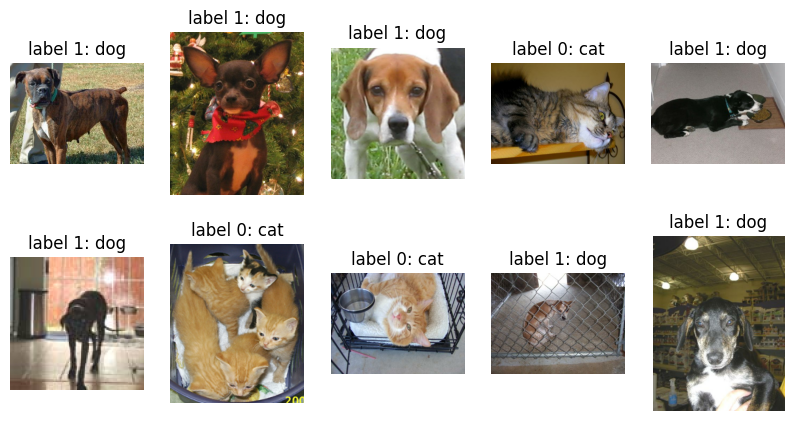

In [4]:
plt.figure(figsize=(10, 5))

get_label_name = ds_info.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져온다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

format_example() 함수를 이용해 이미지를 같은 포맷으로 통일한다.

In [5]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # 입력 이미지 타입을 float32로 바꿈. 더 정밀하게 계산하기 위함.
    image = (image/127.5) - 1 # 픽셀값 정규화 (-1~1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


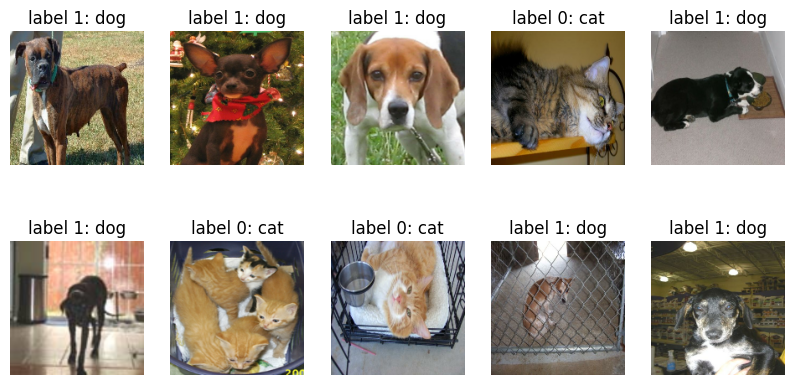

In [6]:
plt.figure(figsize=(10, 5))


get_label_name = ds_info.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [7]:
num_filters = 256
kernel_size = (3,3)
shape = (160,160,256)

In [8]:
def resblock(layer_input, kernel_size, num_filters, naming):
    x = Conv2D(kernel_size=(1, 1), filters = num_filters//4, kernel_initializer = 'he_normal', name='Conv_' + naming + '_a')(layer_input)
    x = BatchNormalization(name = 'BN_' + naming + '_a')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size = kernel_size, padding='same', kernel_initializer = 'he_normal', filters = num_filters//4, name='Conv_' + naming + '_b')(x)
    x = BatchNormalization(name = 'BN_' + naming + '_b')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size = (1, 1), filters = num_filters, kernel_initializer = 'he_normal', name='Conv_' + naming + '_c')(x)
    x = BatchNormalization(name = 'BN_' + naming + '_c')(x)
    x = Add()([layer_input, x])

    x = Activation('relu')(x)

    return x

In [9]:
input_tensor = Input((160, 160, 256))
output_tensor = resblock(input_tensor, (3, 3), 256,'2')

model = Model(inputs = input_tensor, outputs = output_tensor)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 2  0           []                               
                                56)]                                                              
                                                                                                  
 Conv_2_a (Conv2D)              (None, 160, 160, 64  16448       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 BN_2_a (BatchNormalization)    (None, 160, 160, 64  256         ['Conv_2_a[0][0]']               
                                )                                                             

In [10]:
def downsize_block(input_tensor, kernel_size, strides, num_filters, naming):
    x = Conv2D(kernel_size= (1, 1), filters= num_filters//4, strides= strides, kernel_initializer= 'he_normal', name= 'Conv_' + naming + '_a')(input_tensor)
    x = BatchNormalization(name= 'BN_' + naming + '_a')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size= kernel_size, filters= num_filters//4, padding= 'same', kernel_initializer= 'he_normal', name= 'Conv_' + naming + '_b')(x)
    x = BatchNormalization(name= 'BN_' + naming + '_b')(x)
    x = Activation('relu')(x)

    x = Conv2D(kernel_size= (1, 1), filters= num_filters, kernel_initializer= 'he_normal', name= 'Conv_' + naming + '_c')(x)
    x = BatchNormalization(name= 'BN' + naming + '_c')(x)

    shortcut = Conv2D(kernel_size= (1, 1), filters= num_filters, strides= strides, kernel_initializer= 'he_normal', name= 'SC_' + naming)(input_tensor)
    shortcut = BatchNormalization(name= 'SC_BN_' + naming)(shortcut)

    x = Add()([shortcut, x])
    output_tensor = Activation('relu')(x)

    return output_tensor

In [11]:
input_tensor = Input(shape = (56, 56, 256))
output_tensor = downsize_block(input_tensor, kernel_size = (3, 3), strides= (2,2), num_filters=512, naming= 'testblock')

model = Model(inputs = input_tensor, outputs = output_tensor)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 56, 56, 256  0           []                               
                                )]                                                                
                                                                                                  
 Conv_testblock_a (Conv2D)      (None, 28, 28, 128)  32896       ['input_2[0][0]']                
                                                                                                  
 BN_testblock_a (BatchNormaliza  (None, 28, 28, 128)  512        ['Conv_testblock_a[0][0]']       
 tion)                                                                                            
                                                                                            

In [12]:
input_tensor = Input(shape= (160, 160, 3))

def first_convolution(input_tensor):
    x = ZeroPadding2D(padding= (3, 3))(input_tensor)
    x = Conv2D(filters = 64, strides = (2, 2), kernel_size = (7, 7), kernel_initializer= 'he_normal')(x)
    x = BatchNormalization(axis= 3)(x)
    x = Activation('relu')(x)

    return x

def first_pooling(input_tensor):
    x = ZeroPadding2D(padding= (1, 1))(input_tensor)
    x = MaxPool2D(pool_size= (3, 3), strides = (2, 2))(x)

    return x

#첫번째 stage, convolution 수행, strides = 2 로 하여 크기를 반으로
x = first_convolution(input_tensor)

#두번째 stage, pooling 을 적용하여 크기를 반으로 줄이고 첫번째 downsize block 에서는 strides = 1 로 함.
x = first_pooling(x)
x = downsize_block(x, (3, 3), (1, 1), 256, 's2d')
x = resblock(x, (3, 3), 256, 's2r1')
x = resblock(x, (3, 3), 256, 's2r2')

#세번째 stage, block 의 수는 4개
x = downsize_block(x, (3, 3), (2, 2), 512, 's3d')
x = resblock(x, (3, 3), 512, 's3r1')
x = resblock(x, (3, 3), 512, 's3r2')
x = resblock(x, (3, 3), 512, 's3r3')
x = resblock(x, (3, 3), 512, 's3r4')

#네번째 stage, block 의 수는 6개
x = downsize_block(x, (3, 3), (2, 2), 1024, 's4d')
x = resblock(x, (3, 3), 1024, 's4r1')
x = resblock(x, (3, 3), 1024, 's4r2')
x = resblock(x, (3, 3), 1024, 's4r3')
x = resblock(x, (3, 3), 1024, 's4r4')
x = resblock(x, (3, 3), 1024, 's4r5')

#다섯번째 stage, block 의 수는 3개
x = downsize_block(x, (3, 3), (2, 2), 2048, 's5d')
x = resblock(x, (3, 3), 2048, 's5d1')
x = resblock(x, (3, 3), 2048, 's5d2')

#Global Average Pooling 으로 사이즈를 1x1x2048 로 만듦.
x = GlobalMaxPooling2D()(x)
x = Dense(10, activation= 'softmax')(x)

model = Model(inputs = input_tensor, outputs = x)

In [13]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

훈련, 검증 배치 사이즈 설정 

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [17]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 70s 119ms/step - loss: 0.2316 - accuracy: 0.9138 - val_loss: 0.7475 - val_accuracy: 0.8332
Epoch 2/10
582/582 [==============================] - 69s 118ms/step - loss: 0.1777 - accuracy: 0.9375 - val_loss: 0.7381 - val_accuracy: 0.7915
Epoch 3/10
582/582 [==============================] - 69s 118ms/step - loss: 0.1461 - accuracy: 0.9479 - val_loss: 0.6908 - val_accuracy: 0.7932
Epoch 4/10
582/582 [==============================] - 69s 118ms/step - loss: 0.1235 - accuracy: 0.9585 - val_loss: 0.9106 - val_accuracy: 0.7752
Epoch 5/10
582/582 [==============================] - 69s 118ms/step - loss: 0.1097 - accuracy: 0.9631 - val_loss: 0.7106 - val_accuracy: 0.8263
Epoch 6/10
582/582 [==============================] - 69s 118ms/step - loss: 0.0910 - accuracy: 0.9699 - val_loss: 0.7478 - val_accuracy: 0.8444
Epoch 7/10
582/582 [==============================] - 69s 118ms/step - loss: 0.0886 - accuracy: 0.9719 - val_loss: 3.1999 - val_ac

In [16]:
# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'History' object has no attribute 'keys'

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)


predictions

array([[9.46759701e-01, 5.32403290e-02, 9.41126760e-11, 3.63116412e-11,
        6.99758237e-11, 9.03954828e-11, 1.01227131e-10, 1.05854096e-10,
        1.45804327e-10, 4.93436680e-11],
       [4.84867156e-01, 5.15132844e-01, 9.30992672e-10, 2.29144903e-09,
        3.67414793e-10, 1.42087841e-09, 1.92086880e-09, 1.41266909e-09,
        1.43764367e-09, 2.14263851e-09],
       [1.49397478e-01, 8.50602508e-01, 2.03528208e-10, 2.51225540e-10,
        2.68883832e-10, 5.40395007e-10, 1.05523668e-09, 2.88936652e-10,
        6.87688406e-10, 2.74565454e-10],
       [9.19668078e-01, 8.03319216e-02, 1.30695003e-11, 2.06422743e-11,
        7.37211958e-11, 5.13886884e-11, 8.37554748e-11, 3.44139127e-11,
        3.82546599e-11, 4.16850270e-11],
       [8.15607369e-01, 1.84392706e-01, 2.22590321e-10, 1.19988963e-10,
        6.34410302e-11, 8.06010467e-11, 1.40359196e-10, 2.11265477e-10,
        2.23125074e-10, 7.12072762e-11],
       [1.55932698e-02, 9.84406710e-01, 2.94042263e-10, 1.08932995e-10,
   

In [ ]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0], dtype=int64)

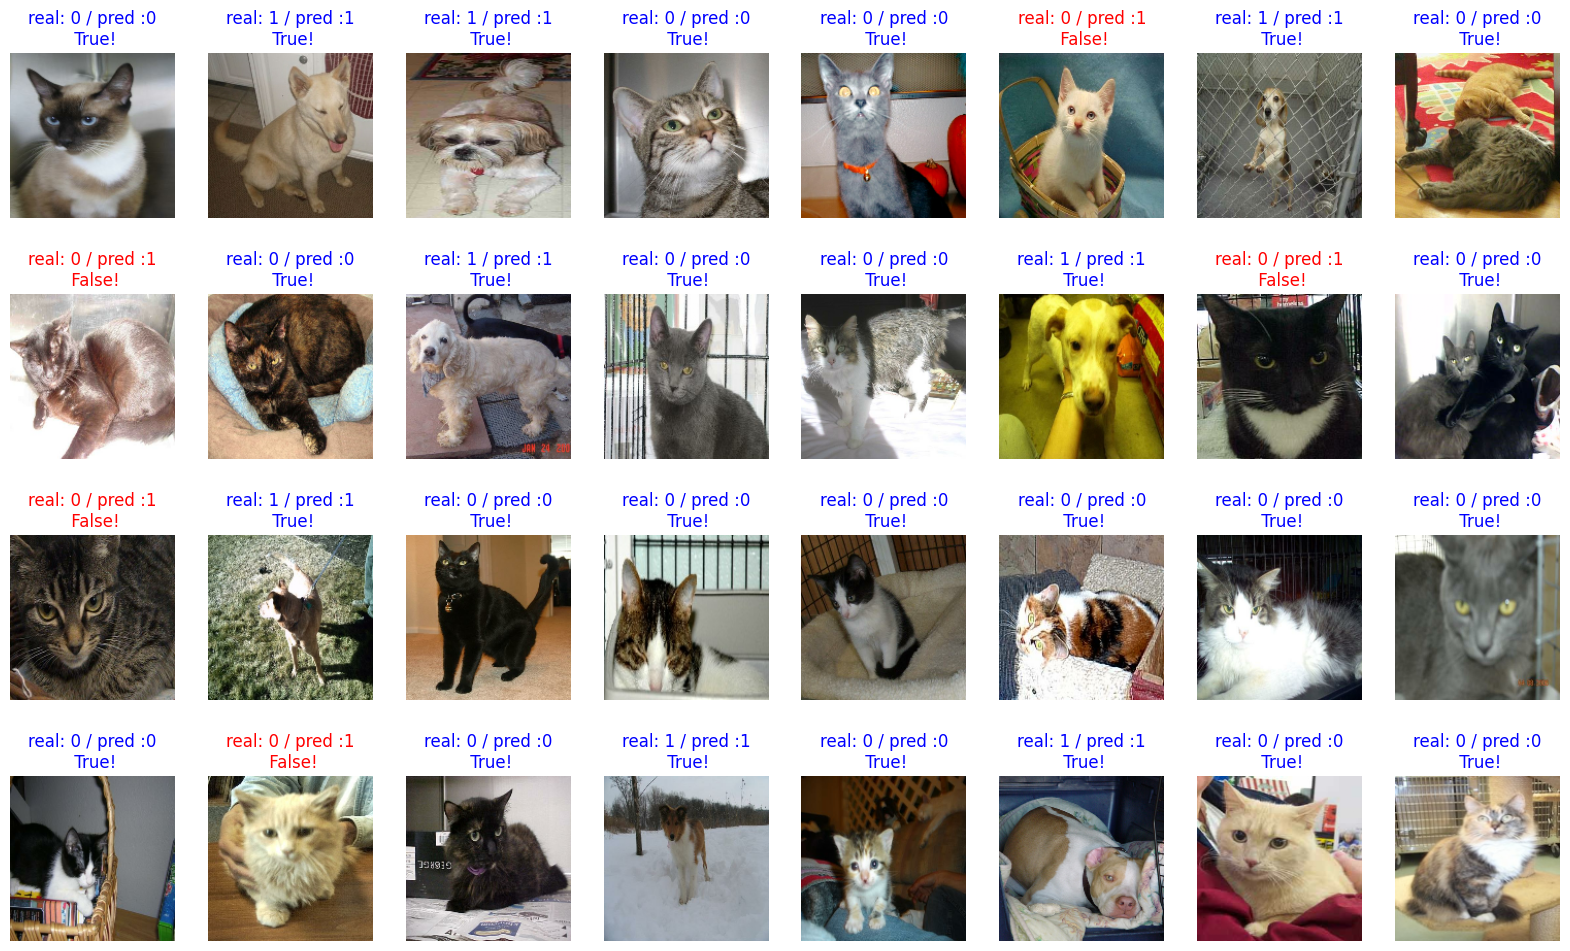

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1


print(count / 32 * 100)

84.375
